# Test case D: FWI L1 norm as an criterion

In [1]:
import os

###############################################################################
# Decide on CPU or GPU here
use_gpu = True  # Set to False if you want CPU only
###############################################################################

if use_gpu:
    # Prevent JAX from preallocating most of the GPU memory
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
    # Force JAX to use GPU
    import jax
    jax.config.update("jax_platform_name", "gpu")
else:
    # Force JAX to use CPU
    import jax
    jax.config.update("jax_platform_name", "cpu")

In [2]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# Now JAX won't pre-allocate GPU memory

In [3]:
import numpy as np
from jax import jit, vjp, vmap, pmap, random, value_and_grad, nn, profiler
import jax
from jax import numpy as jnp
import equinox as eqx
import optax
from matplotlib import pyplot as plt
from jaxdf.operators import compose
from jax.profiler import save_device_memory_profile



from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions, ricker_wavelet, acoustic2D, acoustic2D_pml,acoustic2D_pml_minmem, acoustic2D_pml_4th_minmem
from hybridoed.oed import *


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field


from hybridoed.oed import *

from functools import partial

from jax.example_libraries import optimizers
from tqdm import tqdm

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (
    Domain,
    Medium,
    Sensors,
    Sources,
    TimeAxis,
    circ_mask,
    points_on_circle,
)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth

from jwave.signal_processing import analytic_signal
from jaxdf.operators import gradient, functional

import time


In [4]:
# save_device_memory_profile('memory_profile.json')

# profiler.start_trace('trace')

(500, 1, 70, 70)


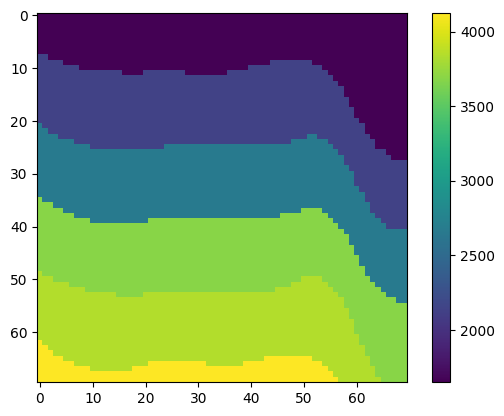

<class 'jaxlib.xla_extension.ArrayImpl'>


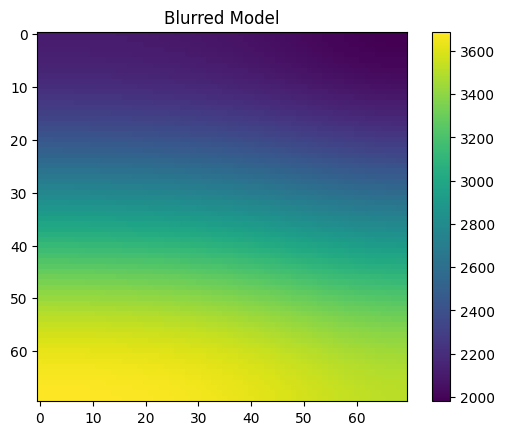

(70, 70)


In [5]:
# Load model

model = jnp.load('model1.npy')

print(model.shape)

model_index = 84

true_model = model[model_index,0,:,:]
# true_model = model
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=20)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap='viridis')
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)

# homogenous model of the velocity avegare

homogenous_model = jnp.ones(true_model.shape) * jnp.mean(true_model)

# plt.imshow(homogenous_model)

## Define domain

In [6]:
# check if the model size and assidn N to it
if true_model.ndim == 2:
    N = true_model.shape
    
dx = (1.0, 1.0)  # Spatial resolution
cfl=0.75

# Defining the domain
domain = Domain(N, dx)
medium = Medium(domain=domain, sound_speed=true_model, density=1000., pml_size=20)


## Define sources and receivers positions

In [7]:
src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)


num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

# mask the sensors positions in the domain
mask = jnp.ones(domain.N)
mask = mask.at[sensors_positions[0], sensors_positions[1]].set(0.0)

print(sensors_positions)
print(source_positions)

(Array([12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 46, 46,
       46, 46, 46, 57, 57, 57, 57, 57], dtype=int32), Array([12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23,
       35, 46, 57, 12, 23, 35, 46, 57], dtype=int32))
(Array([ 5,  5,  5,  5,  5, 20, 20, 20, 20, 20, 35, 35, 35, 35, 35, 50, 50,
       50, 50, 50, 65, 65, 65, 65, 65], dtype=int32), Array([ 5, 20, 35, 50, 65,  5, 20, 35, 50, 65,  5, 20, 35, 50, 65,  5, 20,
       35, 50, 65,  5, 20, 35, 50, 65], dtype=int32))


In [10]:
f0 = 200
dx = dy = 0.8
dt_ben = 12e-5
# n_steps = int(326 * 3.63)
n_steps = int(326 * 0.8)

density = jnp.ones_like(true_model) * 1000.0

# transform the sensors positions to the the same format as the receiver_is
receiver_is_modif = jnp.stack([sensors_positions[0], sensors_positions[1]], axis=-1)
source_modif = jnp.stack([source_positions[0], source_positions[1]], axis=-1)
# make the y coordinate 70 - y coordinate (seond value of the tuple)
# receiver_is_modif = jnp.stack([receiver_is_modif[:,0], 70 - receiver_is_modif[:,1]], axis=-1)
# source_modif = jnp.stack([source_modif[:,0], 70 - source_modif[:,1]], axis=-1)
# print(source_modif,receiver_is_modif)


# Use vmap to simulate wave propagation for all sources
# simulate_for_source = lambda source_i: acoustic2D(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif)
simulate_for_source = lambda source_i: acoustic2D_pml_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=1)
# simulate_for_source = lambda source_i: acoustic2D_pml_4th_minmem(true_model, density, source_i, f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=10)
p_data_ben, wavefields = vmap(simulate_for_source)(source_modif)


In [21]:
gat, wave = acoustic2D_pml(jnp.fliplr(true_model.T), density, source_modif[0], f0, dx, dy, dt_ben, n_steps, receiver_is_modif)
print(source_modif[0])

[5 5]


In [22]:
jnp.fliplr(true_model.T)[5,5]

Array(3841., dtype=float32)

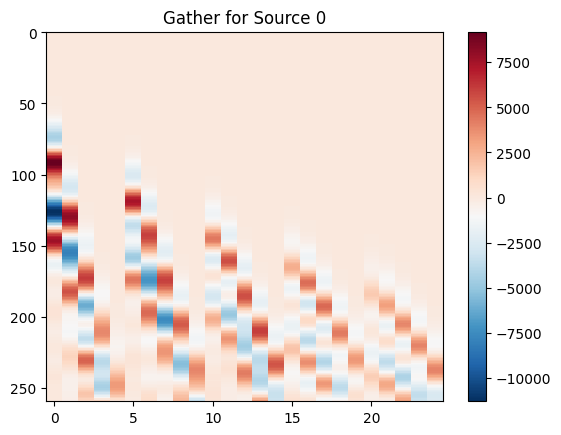

(25, 260, 25)


In [11]:
# plot the gather for the first source
maximum = np.amax(np.abs(p_data_ben[12]))
# minimum = np.amin(p_data_ben[12])
plt.imshow((p_data_ben[0]), cmap="RdBu_r", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title('Gather for Source 0')
plt.show()
print(p_data_ben.shape)

In [10]:
# f0 = 1150
t0 = 1.2 / f0
factor = 1e3
pressure_future = jnp.zeros((N[0], N[1]))
source_i = source_modif[12]
v_source = true_model[source_i[0], source_i[1]]
source_function = []
for it in range(int(n_steps)):
    t = it*dt_ben
    t_source = t
    a = (jnp.pi**2)*f0*f0
    source_term = factor * (1 - 2*a*(t_source-t0)**2)*jnp.exp(-a*(t_source-t0)**2)
    # pressure_future = pressure_future.at[source_i[0], source_i[1]].add(
    #             dt*dt*(4*jnp.pi*(v_source**2)*source_term))# latest seismicCPML normalisation
    source_function.append(dt_ben*dt_ben*(4*jnp.pi*(v_source**2)*source_term))

x_lim = -1
x_axis_ben = jnp.arange(0, len(source_function), 1)*dt_ben
x_axis_jwave = jnp.arange(0, len(signal), 1)*dt_jwave
plt.plot(x_axis_ben[:x_lim],source_function[:x_lim], label='source function Ben')
plt.plot(x_axis_jwave[:x_lim],signal[:x_lim], label='source function j-wave')
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.title('Source Function Comparison')
plt.legend()
plt.show()

print(326*dt_ben)
print(326*dt_jwave)
print(326*dt_jwave / (326*dt_ben))

NameError: name 'signal' is not defined

## Define source wavelet

In [40]:
# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)
t = time_axis.to_array()
dt_jwave = time_axis.dt
print("dt: ", time_axis.dt)
print("t: ", t.shape)

source_freq = 200
source_mag = 1.3e-1
source_mag = source_mag / time_axis.dt



# Parameters
# t_shift = 0.022  # Time shift in seconds
# t_shift = 0.005
t_shift = 1.2 / source_freq  # Time shift in seconds

# Generate the Ricker wavelet with time shift
signal = source_mag * ricker_wavelet(t, source_freq, t_shift)
src_signal = jnp.stack([signal])
print(len(signal))

dt:  0.00018168604583479464
t:  (326,)
326


## Plot the setup

Text(0.5, 1.0, 'Source signals')

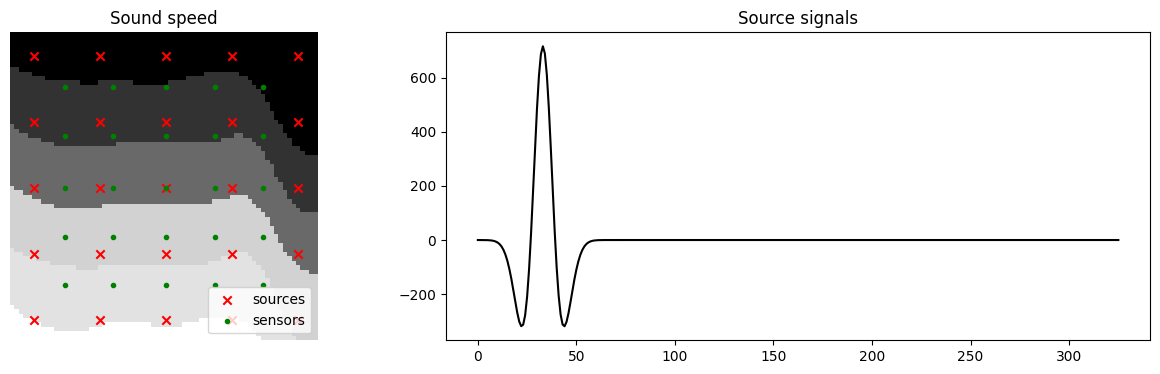

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

## Simulation functions

In [32]:
# FWI functions

@jit
def single_source_simulation(sound_speed, source_num):

    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    
        
    sources = Sources((x, y), src_signal, dt=time_axis.dt, domain=domain)

    # Updating medium with the input speed of sound map
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=10)

    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[..., 0]




In [33]:
def get_sound_speed(params):
    return params + compose(params)(nn.sigmoid) * mask

<class 'int'>


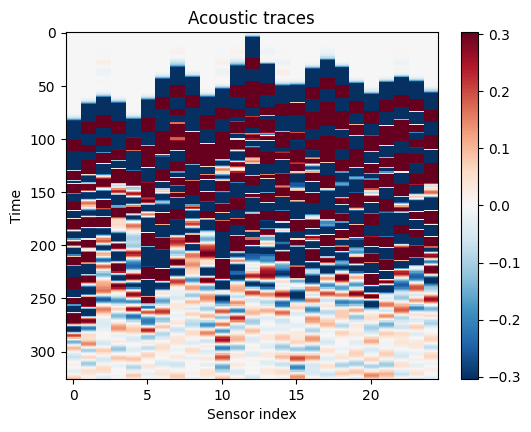

In [34]:
print(type(num_sources//2))
# print(len(source_trajectories[-1][0]))
p = single_source_simulation(medium.sound_speed, num_sources // 2)
# p = single_source_simulation(medium.sound_speed, source_trajectories[-1][0])
# 
# Visualize the acoustic traces
plt.figure(figsize=(6, 4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(
    p, cmap="RdBu_r", interpolation="nearest", aspect="auto",vmin=-maxval/1000, vmax=maxval/1000
)
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()


In [35]:
# Simulate the wave propagation for all sources as the True data

batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
print(p_data.shape)

(25, 326, 25)


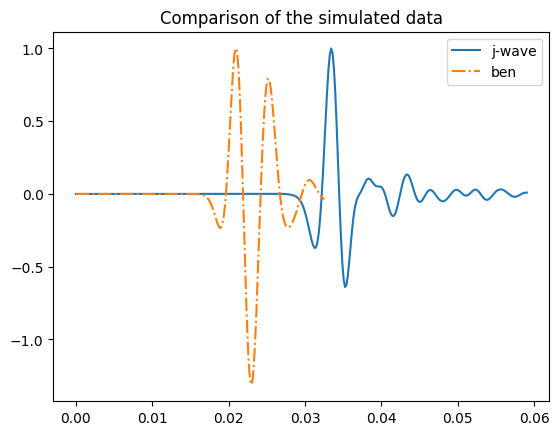

In [96]:
# compare p_data and p_data_ben
src_idx = 0
rec_idx = -1
plt.plot(x_axis_jwave,p_data[src_idx, :, rec_idx]/np.amax(p_data[src_idx, :, rec_idx]), label="j-wave")
plt.plot(x_axis_ben,p_data_ben[src_idx, :, rec_idx]/np.amax(p_data_ben[src_idx, :, rec_idx]),"-.", label="ben")
plt.legend()
plt.title("Comparison of the simulated data")
plt.show()



## Setup for the outer (OED) optimizer

In [12]:
fcn_params = {
    "criterion_threshold": 1e-10,
    "regularisation_loss": 0.0,
    "norm_loss": 0.0,
    "top_k_loss": 0.0,
    "differentiable_mask_sharpness": 10.0,
    "number_of_k":10,
    "hidden_size": 56,
    "num_hidden_layers": 3,
    "learning_rate": 2e-2,
    "num_iterations": 15,
    "print_gradients": False,
    "num_sources": num_sources,
}

In [13]:
#  Load the jacobian data

jacobians = jnp.load("curvel_jac_model_{}_data_5_5_5.npy".format(model_index))
print(jacobians.shape)
transposed_jacobians = jacobians
print(transposed_jacobians.shape)

stacked_array = transposed_jacobians.reshape(transposed_jacobians.shape[0], transposed_jacobians.shape[1]* transposed_jacobians.shape[2],transposed_jacobians.shape[3]*transposed_jacobians.shape[4])
stacked_array.shape

criterion_threshold = fcn_params["criterion_threshold"]

C_sources_1e_3 = [] 
for array in stacked_array:
    C_sources_1e_3.append(eigenvalue_criterion(array, threshold=criterion_threshold))

C_sources_1e_3 = jnp.array(C_sources_1e_3)

# input for the network
x = C_sources_1e_3
x = (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))

# delete stacked array and jacobians and trnposed jacobians from memeory
del jacobians
del transposed_jacobians
del stacked_array

(25, 25, 5, 70, 140)
(25, 25, 5, 70, 140)


In [14]:
# Fully Connected Neural Network
class FullyConnectedNN(eqx.Module):
    layers: list
    # activations: list
    activations: list = eqx.static_field()
    # layers: list = eqx.static_field()


    def __init__(self, input_size, hidden_size, num_hidden_layers, key):
        keys = jax.random.split(key, num_hidden_layers + 1)
        self.layers = [eqx.nn.Linear(input_size, hidden_size, key=keys[0])] + \
                      [eqx.nn.Linear(hidden_size, hidden_size, key=k) for k in keys[1:-1]] + \
                      [eqx.nn.Linear(hidden_size, input_size, key=keys[-1])]
        
        self.activations = [jax.nn.tanh] * num_hidden_layers + [jax.nn.sigmoid]

    def __call__(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

def top_k_regularization(soft_mask, k=10):
    top_k_values = jax.lax.top_k(soft_mask, k)[0]
    penalty = jnp.sum(soft_mask) - jnp.sum(top_k_values)
    return penalty

def smooth_fun(gradient):
    # x = gradient.on_grid[..., 0]
    x = gradient
    for _ in range(1):
        x = smooth(x)
    return x
@jit
def fwi(probabilities):
    num_steps = 150
    key = random.PRNGKey(42)
    _, key = random.split(key)
    # initial model is the blurred model
    params_fwi = blurred_model
    init_fun_fwi, update_fun_fwi, get_params_fwi = optimizers.adam(25.0, 0.9, 0.9)
    opt_state_fwi = init_fun_fwi(params_fwi)

    # print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

    def loss_func_fwi(params_fwi, source_num):
        # c0 = get_sound_speed(params_fwi)
        # p = single_source_simulation(params_fwi, source_num)
        # p, wavefields = acoustic2D_pml(params_fwi, density, source_modif[source_num], f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=5)
        # p, wavefields = acoustic2D(params_fwi, density, source_modif[source_num], f0, dx, dy, dt_ben, n_steps, receiver_is_modif)
        p, wavefields = acoustic2D_pml_minmem(params_fwi, density, source_modif[source_num], f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=1)
        # p, wavefields = acoustic2D_pml_4th_minmem(params_fwi, density, source_modif[source_num], f0, dx, dy, dt_ben, n_steps, receiver_is_modif, pml_width=10)
        data = p_data_ben[source_num]
        # data *= probabilities[source_num]
        # return jnp.mean(jnp.abs(hilbert_transf(p) -hilbert_transf(data)) ** 2)
        # L2 loss
        return jnp.mean((p - data) ** 2)

    loss_with_grad_fwi = value_and_grad(loss_func_fwi, argnums=0)

    # Define and compile the update function
    @jit
    def update_fwi(opt_state, key, k, probabilities):
        v = get_params_fwi(opt_state)
        src_num = random.choice(key, num_sources)
        lossval, gradient = loss_with_grad_fwi(v, src_num)
        gradient = smooth_fun(gradient)
        gradient *= probabilities[src_num]
        return lossval, update_fun_fwi(k, gradient, opt_state)

    @jit
    def body(carry, k):
        opt_state, key = carry
        _, key = random.split(key)      # throw away first, keep second
        lossval, opt_state = update_fwi(opt_state, key, k, probabilities)
        return (opt_state, key), lossval

    (opt_state_fwi, _), losses = lax.scan(body, (opt_state_fwi, key), jnp.arange(num_steps))
    new_params = get_params_fwi(opt_state_fwi)

    return new_params



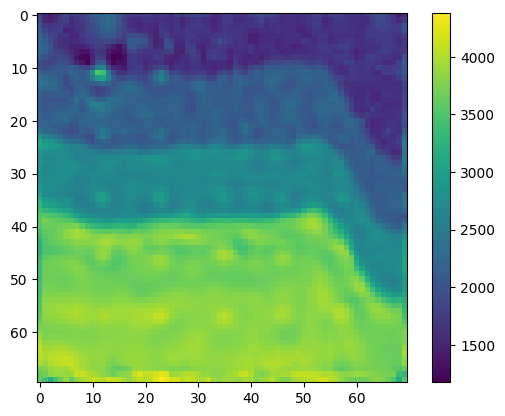

45280.625


In [15]:
# Test the fwi function

iin = fwi(C_sources_1e_3)
plt.imshow(iin)
plt.colorbar()
plt.show()
# L1 loss
print(jnp.linalg.norm((iin - jnp.fliplr(true_model)), ord=1))

In [16]:
# Differentiable Loss Function for the optimizer
def differentiable_loss_fn(model, x ,sharpness=10.0, mask_penalty=0.1):
    probabilities = model(x)  # Predict probabilities
    soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    # multiplier = matrix.shape[0] // soft_mask.shape[0]
    # soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    # weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows

    regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    norm_loss = jnp.linalg.norm(soft_mask, ord=1)
    # top_k_loss = top_k_regularization(soft_mask, k=fcn_params["number_of_k"])

    # singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)
    inverted_model = fwi(probabilities)
    
    fwi_loss = jnp.linalg.norm((inverted_model - true_model), ord=1)

    # fwi_loss = lossval

    # logs["models"].append(inverted_model)


    # return -(singular_loss) + params["regularisation_loss"]*regularization_loss + params["norm_loss"]*norm_loss + params["top_k_loss"]*top_k_loss
    return fwi_loss + fcn_params["regularisation_loss"]*regularization_loss + fcn_params["norm_loss"]*norm_loss 

loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)


In [17]:
# @partial(jit, static_argnums=(1))
@jit
def train_step(model, opt_state, x):
    # Compute loss and gradients
    loss, grads = loss_and_grad_fn(model, x, sharpness=fcn_params["differentiable_mask_sharpness"], mask_penalty=1.0)
    
    if fcn_params["print_gradients"]:  
        jax.tree_util.tree_map(lambda g: print("Gradient shape:", g.shape, "Gradient values:", g), grads)
        jax.tree_util.tree_map(lambda g: print(f"Gradient shape: {g.shape}, Min: {jnp.min(g)}, Max: {jnp.max(g)}, Mean: {jnp.mean(g)}"), grads)

    # Update optimizer state and model
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)

    # Log the network output (predicted probabilities)
    probabilities = model(x)  # Network output
    # logs["probabilities"].append(probabilities)

    # Log the mask M
    soft_mask = differentiable_mask(probabilities, sharpness=fcn_params["differentiable_mask_sharpness"])  # Differentiable mask
    # logs["masks"].append(soft_mask)

    return loss, model, opt_state, probabilities, soft_mask

## Trainning loop

Time taken for step 0: 8.00 seconds
Step 0, Loss: 19389.591796875
Time taken for step 1: 5.12 seconds
Step 1, Loss: 20097.01953125
Time taken for step 2: 5.13 seconds
Step 2, Loss: 19205.35546875
Time taken for step 3: 5.13 seconds
Step 3, Loss: 19015.44140625
Time taken for step 4: 5.13 seconds
Step 4, Loss: 18642.126953125
Time taken for step 5: 5.13 seconds
Step 5, Loss: 17049.615234375
Time taken for step 6: 5.13 seconds
Step 6, Loss: 16377.5234375
Time taken for step 7: 5.12 seconds
Step 7, Loss: 15650.6142578125
Time taken for step 8: 5.13 seconds
Step 8, Loss: 15834.4306640625
Time taken for step 9: 5.13 seconds
Step 9, Loss: 16063.2373046875
Time taken for step 10: 5.13 seconds
Step 10, Loss: 15550.93359375
Time taken for step 11: 5.13 seconds
Step 11, Loss: 15886.71875
Time taken for step 12: 5.13 seconds
Step 12, Loss: 16132.064453125
Time taken for step 13: 5.13 seconds
Step 13, Loss: 16746.287109375
Time taken for step 14: 5.13 seconds
Step 14, Loss: 15851.234375


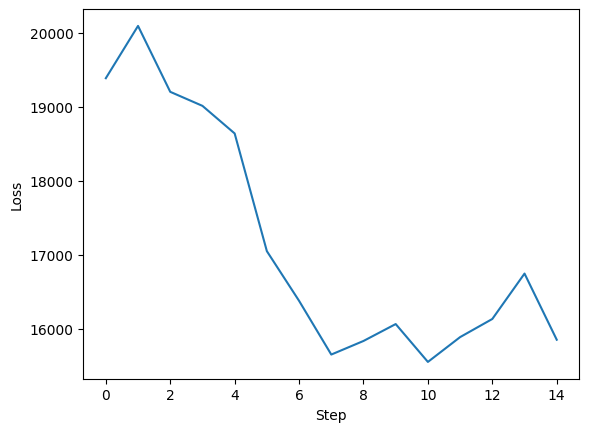

In [18]:

# Initialize the model and optimizer
key = jax.random.PRNGKey(42)
model = FullyConnectedNN(fcn_params["num_sources"], fcn_params["hidden_size"], fcn_params["num_hidden_layers"], key)
optimizer = optax.adamw(fcn_params["learning_rate"])  # Adam optimizer
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))  # Initialize optimizer state
initial_predictions = model(x)  # Initial predictions



# Training loop
num_steps = fcn_params["num_iterations"]
losses = []
logs = {"probabilities": [], "masks": [], "models": []}
for step in range(num_steps):
    tic = time.time()
    
    loss, model, opt_state, probabilities, soft_mask = train_step(model, opt_state, x)
    losses.append(loss)
    logs["probabilities"].append(probabilities)
    logs["masks"].append(soft_mask)



    # inverted_model, lossval = fwi(logs["probabilities"][-1])

    # plt.figure()
    # plt.imshow(inverted_model)
    # plt.colorbar()
    # plt.show()
    
    toc = time.time()
    print("Time taken for step {}: {:.2f} seconds".format(step, toc - tic))

    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()
# 2minutes 25 seconds per iteration on macboook for 200 fwi steps

Step 0: Probabilities: [0.49542153 0.5208084  0.4653499  0.3990476  0.41865003 0.3172414
 0.5869083  0.5083306  0.46009347 0.47156364 0.4828041  0.5287634
 0.5921957  0.4985556  0.5271218  0.55215377 0.5468735  0.58853424
 0.48539567 0.49494764 0.5361377  0.5221632  0.46319267 0.54601574
 0.4840098 ]
Step 0: Mask: [0.48855582 0.5518341  0.4142312  0.26707304 0.30714524 0.13852611
 0.70455486 0.5208144  0.40153697 0.4293843  0.45711586 0.5714168
 0.7154407  0.49638906 0.5673919  0.6275072  0.61508435 0.70792806
 0.46355394 0.48737177 0.58937377 0.55518234 0.4090067  0.6130515
 0.46010944]
Step 1: Probabilities: [0.539394   0.4922393  0.6482079  0.6135295  0.37545678 0.59497154
 0.5085168  0.3484829  0.52939284 0.53085303 0.36898908 0.36706403
 0.528923   0.46959528 0.5016118  0.4053735  0.3985728  0.56596917
 0.5331063  0.41481784 0.44670847 0.4351254  0.22085452 0.5989007
 0.4241399 ]
Step 1: Mask: [0.59723085 0.48060796 0.81488645 0.7568147  0.22349186 0.72105795
 0.5212791  0.1801737

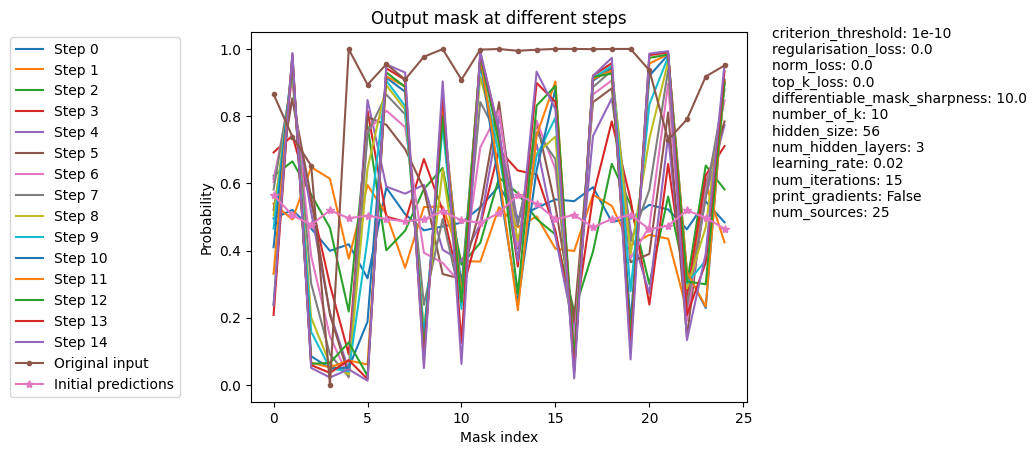

In [19]:
# Print the first few steps for inspection
for i, (probs, mask) in enumerate(zip(logs["probabilities"], logs["masks"])):
    print(f"Step {i}: Probabilities: {probs}")
    print(f"Step {i}: Mask: {mask}")
    if i > 5:  # Limit to first few steps for readability
        break

# Example: Plot the first mask at different training steps
steps_to_plot = [i for i in range(num_steps)]  # Select steps to visualize
plt.figure()

for step in steps_to_plot:
    plt.title(f"Output mask at different steps")
    # plt.plot(logs["masks"][step], label=f"Step {step}")
    plt.plot(logs["probabilities"][step], label=f"Step {step}")
    # plt.colorbar(label="Mask Values")
    plt.xlabel("Mask index")
    plt.ylabel("Probability")

plt.plot(x, ".-", label="Original input")
plt.plot(initial_predictions,"*-", label="Initial predictions")
# put the legend outside of the graph, to the left
plt.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))

# add the params dictionary to the plot, on the right, one key per line
plt.text(1.05, 0.5, '\n'.join([f"{key}: {value}" for key, value in fcn_params.items()]), transform=plt.gca().transAxes)

plt.show()

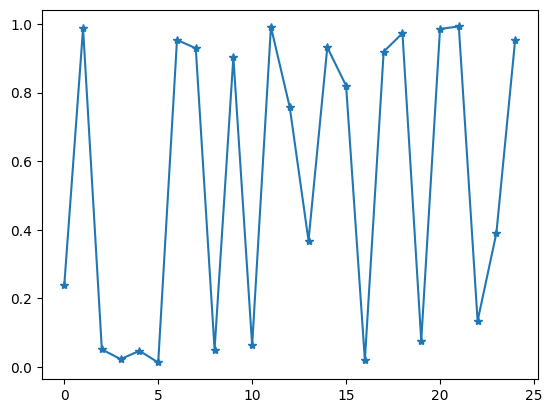

In [20]:
plt.plot(logs["probabilities"][-1],"*-")

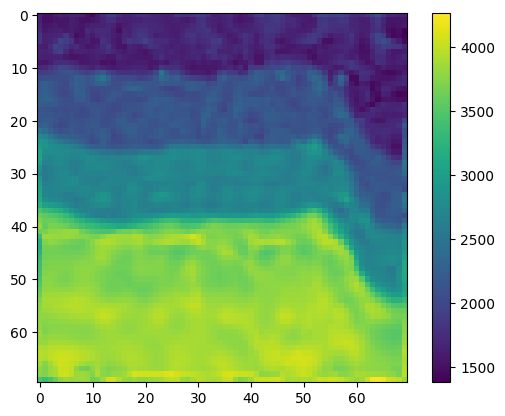

16129.404


In [21]:
invt = fwi(logs["probabilities"][-1])
plt.imshow(invt)
plt.colorbar()
plt.show()  

L1_loss = jnp.linalg.norm((invt - true_model), ord=1)
print(L1_loss)

In [22]:
final_mask = logs["masks"][-1]
best_sources_C = jnp.argsort(final_mask)[-10:]
print("best source index", best_sources_C)

best source index [17  7 14  6 24 18 20  1 11 21]


In [ ]:
# best source index [ 4 19  1  6  0 20  5 18 22  2]

In [ ]:
# model = fwi(final_mask)

In [ ]:
# [11  5 15 17  0  9  8  4 12 13]
# [11  3 13 17 24  2 14 18 21 19] # model 84
# [19  9  5  3 13 22 16 24  0 14] model 84 dataloss
# [19 11  5  3  0  9  8  4 12 13] # model 7 dataloss
# [ 5 18 15  9 10  4  8 17 12 13] # model 7 modelloss
# [15  9 17 21 11  7  8  4 13 12] # model 84 modelloss
# [ 9 23  1 22  6  3 16  2  0 24] # model 84 modelloss probabilties applied to data instead of gradient